In [1]:
#This notebook trains a single RNN using all ten sessions of data and a specified train/test partition
#(can be 'HeldOutBlocks' or 'HeldOutTrials'). The RNN training process is launched in a separate python kernel. 
#This notebook then monitors training progress in real-time by loading data files produced by the RNN trainer
#and plotting them here, so you can watch how it learns over time. 

In [1]:
import numpy as np
import scipy.io
import scipy.ndimage.filters
import os
import matplotlib
import matplotlib.pyplot as plt
import pickle
from datetime import datetime
from charSeqRNN import charSeqRNN, getDefaultRNNArgs

#point this towards the top level dataset directory
rootDir = os.path.expanduser('~') + '/AIResearch/handwritingBCIDatacopy/'

#train an RNN using data from these specified sessions
dataDirs = ['t5.2019.05.08','t5.2019.11.25','t5.2019.12.09','t5.2019.12.11','t5.2019.12.18',
            't5.2019.12.20','t5.2020.01.06','t5.2020.01.08','t5.2020.01.13','t5.2020.01.15']

#use this train/test partition 
cvPart = 'HeldOutTrials'

#name of the directory where this RNN run will be saved
rnnOutputDir = cvPart

#all RNN runs are saved in 'Step4_RNNTraining'
if not os.path.isdir(rootDir + 'RNNTrainingSteps/Step4_RNNTraining'):
    os.mkdir(rootDir + 'RNNTrainingSteps/Step4_RNNTraining')

/opt/anaconda3/envs/tf-py3.6-1.15.0/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/tf-py3.6-1.15.0/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/tf-py3.6-1.15.0/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/tf-py3.6-1.15.0/lib/pyt

In [2]:
#We will use the default arguments specified here
args = getDefaultRNNArgs()

#Configure the arguments for a multi-day RNN (that will have a unique input layer for each day)
for x in range(len(dataDirs)):
    args['sentencesFile_'+str(x)] = rootDir+'Datasets/'+dataDirs[x]+'/sentences.mat'
    args['singleLettersFile_'+str(x)] = rootDir+'Datasets/'+dataDirs[x]+'/singleLetters.mat'
    args['labelsFile_'+str(x)] = rootDir+'RNNTrainingSteps/Step2_HMMLabels/'+cvPart+'/'+dataDirs[x]+'_timeSeriesLabels.mat'
    args['syntheticDatasetDir_'+str(x)] = rootDir+'RNNTrainingSteps/Step3_SyntheticSentences/'+cvPart+'/'+dataDirs[x]+'_syntheticSentences/'
    args['cvPartitionFile_'+str(x)] = rootDir+'RNNTrainingSteps/trainTestPartitions_'+cvPart+'.mat'
    args['sessionName_'+str(x)] = dataDirs[x]
    
args['outputDir'] = rootDir+'RNNTrainingSteps/Step4_RNNTraining/'+rnnOutputDir
if not os.path.isdir(args['outputDir']):
    os.mkdir(args['outputDir'])
    
#this weights each day equally (0.1 probability for each day) and allocates a unique input layer for each day (0-9)
args['dayProbability'] = '[0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]'
args['dayToLayerMap'] = '[0,1,2,3,4,5,6,7,8,9]'

#save the arguments dictionary so that the RNN program can load it
pickle.dump( args, open( args['outputDir'] + '/args.p', "wb" ) )

In [3]:
#The following code snippet will launch an RNN training program in a separate python kernel (so it doesn't launch inside
#the jupyter notebook, which can be unstable).
import os
argsFile = args['outputDir'] + '/args.p'
scriptFile = os.getcwd()+'/charSeqRNN.py'
print('python3 ' + scriptFile + ' --argsFile=' + argsFile + ' &')
#os.system('python3 ' + scriptFile + ' --argsFile=' + argsFile + ' &')

python3 /Users/aashnahari/AIResearch/handwritingBCIcopy/charSeqRNN.py --argsFile=/Users/aashnahari/AIResearch/handwritingBCIDatacopy/RNNTrainingSteps/Step4_RNNTraining/HeldOutTrials/args.p &


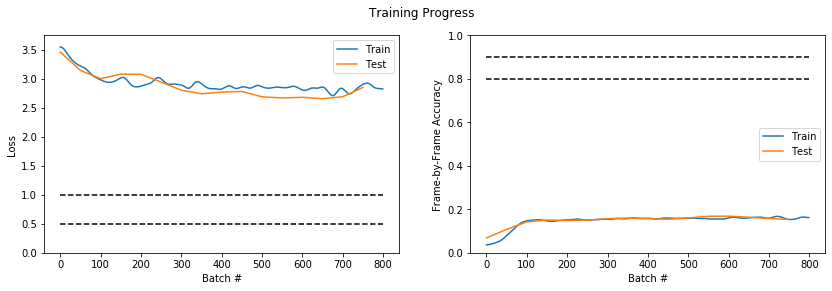

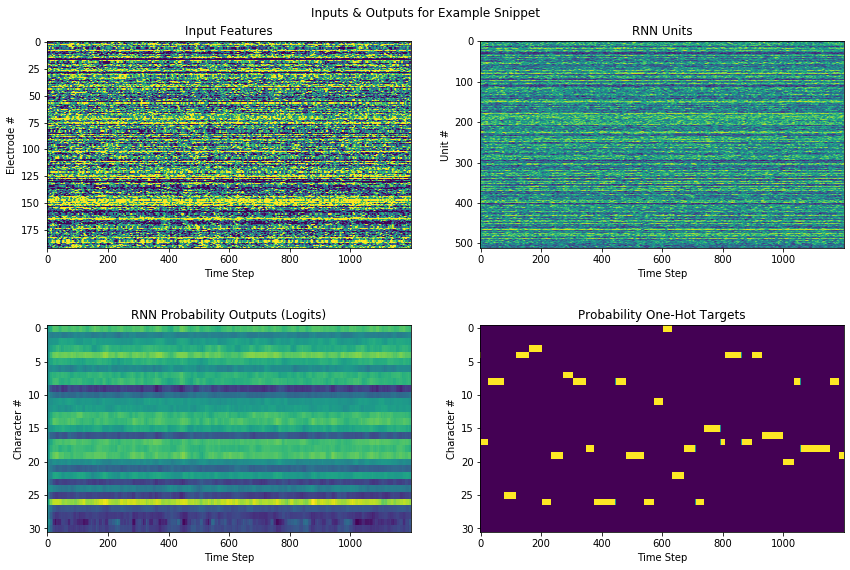

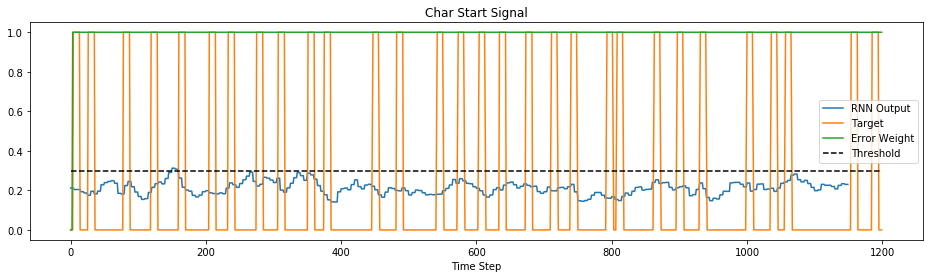

In [ ]:
#Run this cell to visualize the training process in real-time. You can stop it at any time without interrupting the
#training.
import time
from IPython import display
from scipy.ndimage.filters import gaussian_filter1d

while True:
    #The RNN training process periodically saves off performance statistics and a snapshot of RNN outputs, which we load here.
    try:
        snapshot = scipy.io.loadmat(args['outputDir'] + '/outputSnapshot.mat')
        intOut = scipy.io.loadmat(args['outputDir'] + '/intermediateOutput.mat')
    except:
        time.sleep(30)
        continue
    
    display.clear_output(wait=True)

    plotEnd = np.argwhere(intOut['batchTrainStats'][:,0]==0)
    plotEnd = plotEnd[1][0]-1
    
    plotEndVal = np.argwhere(intOut['batchValStats'][:,0]==0)
    plotEndVal = plotEndVal[1][0]-1
    
    #----Training loss & frame-by-frame accuracy----
    plt.figure(figsize=(14,4))
    plt.subplot(1,2,1)
    plt.plot(intOut['batchTrainStats'][0:plotEnd,0], gaussian_filter1d(intOut['batchTrainStats'][0:plotEnd,1], 10))
    plt.plot(intOut['batchValStats'][0:plotEndVal,0], gaussian_filter1d(intOut['batchValStats'][0:plotEndVal,1], 1))
    plt.plot([0, intOut['batchValStats'][plotEndVal,0]], [0.5, 0.5],'--k') #guidelines for visualization
    plt.plot([0, intOut['batchValStats'][plotEndVal,0]], [1.0, 1.0],'--k')
    plt.xlabel('Batch #')
    plt.legend(['Train','Test'])
    plt.ylim([0,3.75])
    plt.ylabel('Loss')
    
    plt.subplot(1,2,2)
    plt.plot(intOut['batchTrainStats'][0:plotEnd,0], gaussian_filter1d(intOut['batchTrainStats'][0:plotEnd,3], 10))
    plt.plot(intOut['batchValStats'][0:plotEndVal,0], gaussian_filter1d(intOut['batchValStats'][0:plotEndVal,3], 1))
    plt.plot([0, intOut['batchValStats'][plotEndVal,0]], [0.8, 0.8],'--k') #guidelines for visualization
    plt.plot([0, intOut['batchValStats'][plotEndVal,0]], [0.9, 0.9],'--k')
    plt.ylim([0,1.0])
    plt.xlabel('Batch #')
    plt.legend(['Train','Test'])
    plt.ylabel('Frame-by-Frame Accuracy')
    
    plt.suptitle('Training Progress')

    display.display(plt.gcf())
    plt.close()
        
    #----RNN outputs & training targets----
    plt.figure(figsize=(12.45, 8.3))
    plt.subplot(2,2,1)
    plt.imshow(np.transpose(snapshot['inputs']),aspect='auto',clim=[-1,1])
    plt.title('Input Features')
    plt.ylabel('Electrode #')
    plt.xlabel('Time Step')

    plt.subplot(2,2,2)
    plt.imshow(np.transpose(snapshot['rnnUnits']),aspect='auto',clim=[-1,1])
    plt.title('RNN Units')
    plt.ylabel('Unit #')
    plt.xlabel('Time Step')

    plt.subplot(2,2,3)
    plt.imshow(np.transpose(snapshot['charProbOutput']),aspect='auto')
    plt.title('RNN Probability Outputs (Logits)')
    plt.ylabel('Character #')
    plt.xlabel('Time Step')

    plt.subplot(2,2,4)
    plt.imshow(np.transpose(snapshot['charProbTarget']),aspect='auto')
    plt.title('Probability One-Hot Targets')
    plt.ylabel('Character #')
    plt.xlabel('Time Step')

    plt.tight_layout(pad=3)
    plt.suptitle('Inputs & Outputs for Example Snippet')
    display.display(plt.gcf())
    plt.close()

    plt.figure(figsize=(16,4))
    plt.plot(np.squeeze(snapshot['charStartOutput']))
    plt.plot(np.squeeze(snapshot['charStartTarget']))
    plt.plot(np.squeeze(snapshot['errorWeight']))
    plt.plot([0,snapshot['errorWeight'].shape[1]],[0.3,0.3],'--k')
    plt.title('Char Start Signal')
    plt.xlabel('Time Step')
    plt.legend(['RNN Output','Target','Error Weight','Threshold'])
    
    display.display(plt.gcf())
    plt.close()
    
    time.sleep(30)